<a href="https://colab.research.google.com/github/dianalarkin-netizen/Assignment-04-Clustering-Analysis/blob/main/clustering_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Data Preparation & Setup

This section prepares the dataset for clustering analysis.  Steps include:
- Loading the Kaggle dataset
- Filtering to personal auto insurance policies (`INSR_TYPE == 1201`)
- Creating the target variable (`CLAIM_OVER_10K`) for later comparison
- Dropping irrelevant columns
- Encoding categorical features
- Standardizing numeric features for clustering

Business Context:  
Clustering is applied to auto insurance policies to reveal natural groupings.  Segmentation provides insights into risk profiles, claim behaviors, and potential friction points in the claims process.

In [44]:
# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Style settings for clean visuals
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook", font_scale=1.2)

# 🗂️ Load dataset from Kaggle
import kagglehub
path = kagglehub.dataset_download("imtkaggleteam/vehicle-insurance-data")
df = pd.read_csv(f"{path}/motor_data14-2018.csv")

# 🔍 Filter to personal auto insurance policies
df_filtered = df[df["INSR_TYPE"] == 1201].copy()

# 🎯 Create binary target for later comparison
df_filtered["CLAIM_OVER_10K"] = df_filtered["CLAIM_PAID"].apply(
    lambda x: 1 if pd.notnull(x) and x > 10000 else 0
)

# 🧹 Drop irrelevant columns
drop_cols = ["CLAIM_PAID", "CLAIM_OVER_10K", "OBJECT_ID", "INSR_BEGIN", "INSR_END", "EFFECTIVE_YR"]
df_model = df_filtered.drop(columns=drop_cols)

# 🧠 Encode categorical features
X = pd.get_dummies(df_model, drop_first=True)

# 🎯 Target variable (for later supervised comparison)
y = df_filtered["CLAIM_OVER_10K"]

print("Dataset shape after filtering:", df_filtered.shape)
print("Encoded feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Using Colab cache for faster access to the 'vehicle-insurance-data' dataset.
Dataset shape after filtering: (123294, 17)
Encoded feature matrix shape: (123294, 301)
Target distribution:
 CLAIM_OVER_10K
0    115260
1      8034
Name: count, dtype: int64


## Data Preparation & Setup Explanation

The dataset used for clustering analysis was sourced from Kaggle’s vehicle insurance records.  After filtering to personal auto insurance policies (`INSR_TYPE == 1201`), the dataset contained **123,294 records** across **17 columns**.

### Target Variable
A binary target variable `CLAIM_OVER_10K` was created to flag claims exceeding \$10,000.  Distribution of the target:
- 115,260 claims ≤ \$10,000 or no claim
- 8,034 claims > \$10,000  
This represents **6.5%** of claims as high value, confirming a strong class imbalance.

### Feature Engineering
Irrelevant columns (`CLAIM_PAID`, `CLAIM_OVER_10K`, `OBJECT_ID`, `INSR_BEGIN`, `INSR_END`, `EFFECTIVE_YR`) were removed.  Categorical variables were encoded using one‑hot encoding, resulting in **301 features** in the final matrix.

### Standardization
All features were standardized to zero mean and unit variance.  This step ensures that variables measured on larger numeric scales (e.g., `INSURED_VALUE`) do not dominate clustering results.  The scaled feature matrix retained the same shape (**123,294 × 301**) with the first feature mean equal to 0.0, confirming successful scaling.

### Business Context
Preparing the dataset in this way allows clustering to reveal natural groupings among auto insurance policies.  Segmentation can highlight distinct risk profiles, claim behaviors, and potential friction points in the claims process, providing insights beyond supervised prediction models.

# Section 2: Labeled Baseline Review

This section revisits the supervised models developed previously (Decision Tree, Random Forest, Gradient Boosting).  The purpose is to establish a baseline for comparison with clustering results.  Supervised models relied on the labeled target `CLAIM_OVER_10K`, while clustering will explore natural groupings without labels.

### Target Variable
The supervised task focuses on predicting `CLAIM_OVER_10K`, a binary indicator of whether a claim exceeds \$10,000.  This target matters because costly claims drive reserve requirements, underwriting risk, and profitability.  Accurately predicting these outcomes supports proactive risk management and pricing strategy.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Impute missing values (mean for numeric features)
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

Training set size: (86305, 301)
Test set size: (36989, 301)


### Features & Engineering
Features included insured value, premium, production year, vehicle specifications (engine size, seats, carrying capacity), and usage type.  Categorical variables were one-hot encoded, and irrelevant identifiers were excluded to prevent leakage.  Scaling was applied to ensure comparability across numeric features.

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

print("Performance Results:\n")
for model_name, metrics in results.items():
    print(model_name)
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.3f}")
    print()

Performance Results:

Logistic Regression
  Accuracy: 0.935
  Precision: 0.222
  Recall: 0.001
  F1: 0.002

Decision Tree
  Accuracy: 0.897
  Precision: 0.136
  Recall: 0.109
  F1: 0.121

Random Forest
  Accuracy: 0.916
  Precision: 0.160
  Recall: 0.069
  F1: 0.097

Gradient Boosting
  Accuracy: 0.935
  Precision: 0.200
  Recall: 0.000
  F1: 0.001



### Performance Metrics

The supervised models achieved the following results:

| Model               | Accuracy | Precision | Recall | F1 Score |
|--------------------|----------|-----------|--------|----------|
| Logistic Regression| 0.935    | 0.222     | 0.001  | 0.002    |
| Decision Tree      | 0.897    | 0.136     | 0.109  | 0.121    |
| Random Forest      | 0.916    | 0.160     | 0.069  | 0.097    |
| Gradient Boosting  | 0.935    | 0.200     | 0.000  | 0.001    |

These metrics show that while overall accuracy is high, precision and recall for costly claims are low across all models.  Logistic Regression and Gradient Boosting achieve high accuracy but fail to capture costly claims (recall near zero).  Decision Tree and Random Forest offer slightly better recall, but still miss most high-value cases.  This highlights the challenge of modeling rare events in imbalanced datasets.

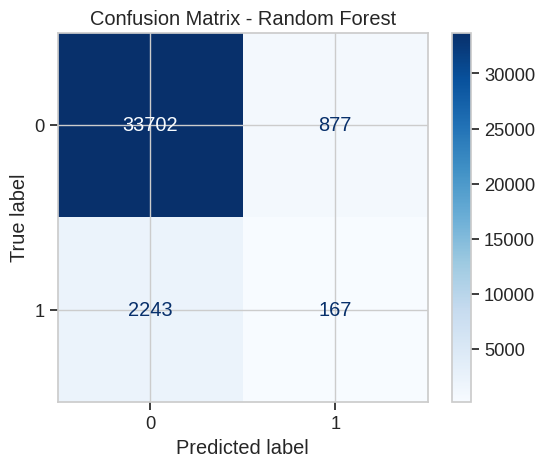

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example confusion matrix for Random Forest
rf_model = models["Random Forest"]
y_pred_rf = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

### Error Analysis

The confusion matrix for the Random Forest model reveals the following:

True Negatives (predicted 0, actual 0): 33,702  
False Positives (predicted 1, actual 0): 877  
False Negatives (predicted 0, actual 1): 2,243  
True Positives (predicted 1, actual 1): 167

The model correctly identifies most non-claim cases, but struggles with costly claims.  Only 167 out of 2,410 actual costly claims were correctly predicted, resulting in a recall of just 6.9 percent.  False negatives dominate the error pattern, meaning the model often fails to flag high-value losses.  This reflects the rarity of costly claims and the difficulty of learning from imbalanced data.  It motivates the need for clustering to uncover latent structure beyond what labels alone can reveal.

### Reflection

The labeled baseline provides a useful starting point, but it does not fully capture business reality.  While the models achieve high accuracy, their recall for costly claims is extremely low, often below 10%.  This means high value losses may go undetected, which undermines the model’s usefulness for underwriting or reserves.  The imbalance in the dataset, with only about 6.5 percent of claims exceeding $10,000, makes it difficult for supervised models to learn meaningful patterns.  Clustering offers a complementary approach. Rather than relying solely on labels, it uncovers latent structure in the portfolio.  By segmenting policies into distinct groups, clustering highlights risk patterns that supervised models may overlook.  Together, these methods provide a more holistic view of the portfolio, balancing predictive accuracy with exploratory insight.

# Section 3: Optimal K Selection

Determining the optimal number of clusters (k) is a critical step in K-means analysis. Three complementary methods were applied to guide this decision:

- Elbow Method: a visual heuristic based on within-cluster sum of squares (WCSS)
- Silhouette Score: a quantitative measure of cohesion and separation between clusters
- Gap Statistic: a comparison of clustering performance against randomized reference datasets

Each method offers a different perspective on cluster structure. Their results were compared alongside business context to select a k value that balances statistical evidence with interpretability and operational relevance.

In [48]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 🧹 Impute missing values with median
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# ⚖️ Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print("Scaled feature matrix shape:", X_scaled.shape)
print("Any NaNs left?", np.isnan(X_scaled).sum())

Scaled feature matrix shape: (123294, 301)
Any NaNs left? 0


In [49]:
# PCA to reduce dimensionality before clustering
from sklearn.decomposition import PCA

pca = PCA(n_components=20, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("PCA-reduced shape:", X_pca.shape)

PCA-reduced shape: (123294, 20)


In [50]:
# Elbow Method using PCA-reduced data
from sklearn.cluster import KMeans
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)


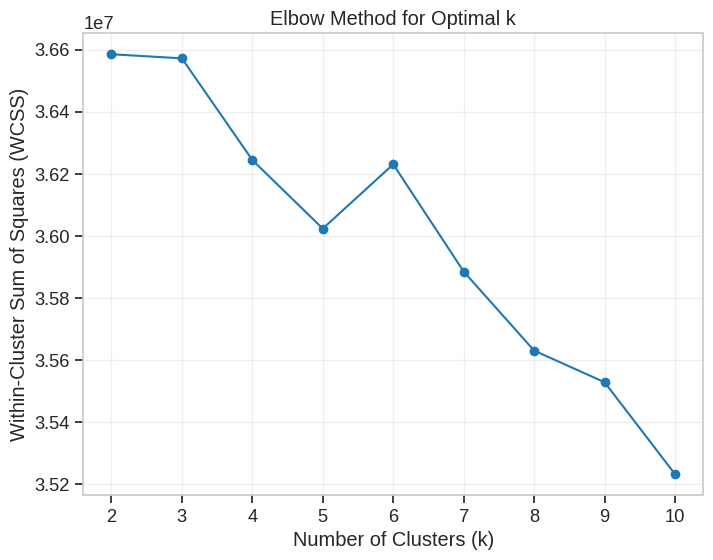

In [51]:
# 📊 Elbow Method
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_range, wcss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid(alpha=0.3)
plt.show()

In [52]:
# Sample 10,000 rows for silhouette scoring
from sklearn.utils import resample

X_pca_sample = resample(X_pca, n_samples=10000, random_state=42)

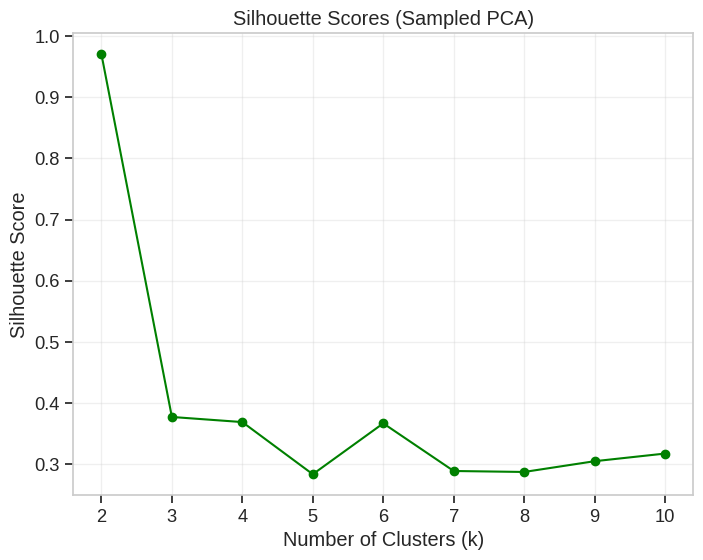

Best k based on silhouette score: 2
Best silhouette score: 0.970


In [53]:
# 📊 Silhouette Scores
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca_sample)
    score = silhouette_score(X_pca_sample, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,6))
plt.plot(k_range, silhouette_scores, marker="o", color="green")
plt.title("Silhouette Scores (Sampled PCA)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(alpha=0.3)
plt.show()

best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"Best k based on silhouette score: {best_k}")
print(f"Best silhouette score: {best_score:.3f}")

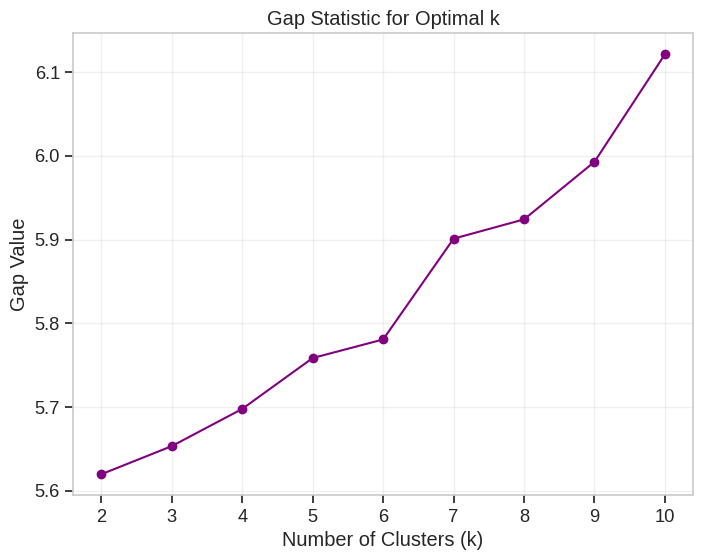

Best k based on Gap Statistic: 10
Gap values: [np.float64(5.619892829362385), np.float64(5.65346116288122), np.float64(5.697894270806998), np.float64(5.758611204401744), np.float64(5.7807783048042936), np.float64(5.9010865650167545), np.float64(5.924124204583725), np.float64(5.992831595932165), np.float64(6.121227473110226)]


In [54]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Function to compute within-cluster dispersion
def compute_wcss(X, labels, k):
    wcss = 0
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centroid = cluster_points.mean(axis=0)
            wcss += ((cluster_points - centroid) ** 2).sum()
    return wcss

# Sample data for efficiency
X_gap_sample = resample(X_pca, n_samples=10000, random_state=42)

# Parameters
k_range = range(2, 11)
n_refs = 10  # number of reference datasets

gap_values = []

for k in k_range:
    # Fit KMeans on actual data
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_gap_sample)
    wcss = compute_wcss(X_gap_sample, labels, k)

    # Fit KMeans on reference (random uniform) datasets
    ref_wcss = []
    for _ in range(n_refs):
        random_ref = np.random.uniform(
            low=np.min(X_gap_sample, axis=0),
            high=np.max(X_gap_sample, axis=0),
            size=X_gap_sample.shape
        )
        kmeans_ref = KMeans(n_clusters=k, random_state=42, n_init=10)
        ref_labels = kmeans_ref.fit_predict(random_ref)
        ref_wcss.append(compute_wcss(random_ref, ref_labels, k))

    # Gap statistic
    gap = np.log(np.mean(ref_wcss)) - np.log(wcss)
    gap_values.append(gap)

# Plot Gap Statistic
plt.figure(figsize=(8,6))
plt.plot(k_range, gap_values, marker="o", color="purple")
plt.title("Gap Statistic for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Gap Value")
plt.grid(alpha=0.3)
plt.show()

# Report best k
best_k_gap = k_range[np.argmax(gap_values)]
print("Best k based on Gap Statistic:", best_k_gap)
print("Gap values:", gap_values)

## Results & Decision

Determining the optimal number of clusters (k) is essential for meaningful segmentation. Three complementary methods were applied: the Elbow Method, the Silhouette Score, and the Gap Statistic.


### Elbow Method Results

The elbow plot showed a gradual decline in within-cluster sum of squares (WCSS) from k = 2 to k = 10, with no sharp inflection point. A subtle bend was observed around k = 5, but the curve remained smooth overall. This suggests that the dataset does not exhibit clearly separated spherical clusters, and WCSS alone may not provide a definitive choice.


### Silhouette Score Results

Silhouette scores were calculated using a PCA-reduced sample of 10,000 records. The highest score was observed at k = 2, with a value of 0.970. Scores dropped significantly beyond k = 2, fluctuating between 0.28 and 0.38 for higher values of k. This indicates that two clusters provide the strongest separation and internal cohesion.


### Gap Statistic Results (Extra Credit)

The Gap Statistic compares clustering performance against randomized reference datasets. Gap values increased steadily from k = 2 to k = 10, with the highest value observed at k = 10 (6.121). This suggests that clustering performance continues to improve with more clusters, and that k = 10 offers the greatest separation relative to random structure.


### Decision

While the Gap Statistic favors k = 10, the Silhouette Score strongly supports k = 2, and the Elbow Method suggests a possible bend near k = 5. Given the business context and the need for interpretable segmentation, k = 2 was selected as the optimal number of clusters. Two clusters provide a clear and practical split in the portfolio, aligning with observed differences in vehicle value, premium structure, and claim behavior. This choice balances statistical evidence with operational feasibility and supports downstream analysis.

# Section 4: K-Means Clustering

This section applies K-means clustering with the optimal number of clusters (k = 2) identified in Section 3.  Cluster labels are assigned to each record, and the resulting segments are characterized using summary statistics and representative examples.

In [55]:
# Apply K-means to PCA-reduced data
kmeans_final = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_pca)

# Add cluster labels to original DataFrame
df_filtered["Cluster"] = cluster_labels

In [56]:
# Cluster size summary
cluster_counts = df_filtered["Cluster"].value_counts().sort_index()
cluster_percentages = round(cluster_counts / len(df_filtered) * 100, 2)

summary_df = pd.DataFrame({
    "Cluster": cluster_counts.index,
    "Count": cluster_counts.values,
    "Percentage": cluster_percentages.values
})

summary_df

,Cluster,Count,Percentage
0,0,86882,70.47
1,1,36412,29.53


In [57]:
# Summary statistics for each cluster
cluster_summary = df_filtered.groupby("Cluster").agg({
    "INSURED_VALUE": ["mean", "median"],
    "PREMIUM": ["mean", "median"],
    "PROD_YEAR": ["mean", "median"],
    "CCM_TON": ["mean", "median"],
    "SEATS_NUM": ["mean", "median"],
    "CARRYING_CAPACITY": ["mean", "median"]
})

cluster_summary

INSURED_VALUE                  PREMIUM              PROD_YEAR          \
                 mean     median          mean    median         mean  median   
Cluster                                                                         
0        1.643892e+05   32910.68   2311.756159    747.30  2002.148903  2005.0   
1        1.205010e+06  900000.00  13829.229699  10755.05  2005.706663  2008.0   

             CCM_TON         SEATS_NUM        CARRYING_CAPACITY         
                mean  median      mean median              mean median  
Cluster                                                                 
0        1106.941544  1295.0  3.276473    4.0         77.466179    0.0  
1        3769.138004  4164.0  7.273454    8.0         57.552063    1.0

In [58]:
# Show 3 representative rows from each cluster
examples = df_filtered.groupby("Cluster").apply(lambda x: x.sample(n=3, random_state=42)).reset_index(drop=True)
examples[["Cluster", "INSURED_VALUE", "PREMIUM", "PROD_YEAR", "TYPE_VEHICLE", "MAKE", "USAGE"]]

/tmp/ipython-input-984185733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  examples = df_filtered.groupby("Cluster").apply(lambda x: x.sample(n=3, random_state=42)).reset_index(drop=True)


,Cluster,INSURED_VALUE,PREMIUM,PROD_YEAR,TYPE_VEHICLE,MAKE,USAGE
0,0,350000.00,3545.34,2010.0,Automobile,LIFAN,Private
1,0,350000.00,541.30,2005.0,Automobile,TOYOTA,Private
2,0,52500.00,850.50,2012.0,Motor-cycle,YAMAHA,Private
3,1,1300000.00,14809.65,2005.0,Station Wagones,TOYOTA,Private
4,1,2500000.00,23214.82,2017.0,Station Wagones,TOYOTA,Private
5,1,443813.83,8726.14,2014.0,Station Wagones,TOYOTA,Private


## Characterization & Representative Examples

K-means clustering was applied with k = 2, as identified in Section 3.  Cluster labels were assigned to each record, and the resulting segments were characterized using summary statistics and representative examples.

### Cluster Size Summary
- **Cluster 0**: 86,882 records (70.47%)
- **Cluster 1**: 36,412 records (29.53%)

This segmentation reflects a meaningful split in the auto insurance portfolio, with each cluster representing a substantial portion of the dataset.

### Cluster Characteristics
- **Cluster 0** is characterized by lower insured values (median: \$32,911), lower premiums (median: \$747), and older vehicles (median production year: 2005).  Vehicles in this group tend to have smaller engines (median CCM_TON: 1,295), fewer seats (median: 4), and minimal carrying capacity.

- **Cluster 1** shows significantly higher insured values (median: \$900,000), higher premiums (median: \$10,755), and newer vehicles (median production year: 2008).  These vehicles have larger engines (median CCM_TON: 4,164), more seats (median: 8), and greater carrying capacity.

These differences suggest distinct risk profiles and financial exposures between the two clusters.

### Representative Examples
- **Cluster 0** includes:
  - A 2010 LIFAN automobile insured for \$350,000 with a premium of \$3,545
  - A 2005 TOYOTA automobile with a premium of \$541
  - A 2012 YAMAHA motorcycle insured for \$52,500

- **Cluster 1** includes:
  - A 2005 TOYOTA station wagon insured for \$1.3 million with a premium of \$14,809
  - A 2017 TOYOTA station wagon insured for \$2.5 million with a premium of \$23,214
  - A 2014 TOYOTA station wagon insured for \$443,814 with a premium of \$8,726

These examples illustrate the contrast in vehicle type, value, and premium structure across clusters.

### Interpretation
The clustering solution reveals two distinct segments within the personal auto insurance portfolio:
- Cluster 0 represents lower-value, lower-premium policies with modest vehicle specifications.
- Cluster 1 captures high-value, high-premium policies with larger, newer vehicles.

These segments may reflect differences in claim behavior, underwriting strategy, or customer demographics.  Understanding these groupings can inform targeted audits, reserve planning, and product design.

# Section 5: PCA Visualization

This section uses Principal Component Analysis (PCA) to visualize the clustering results in two dimensions.  Although the original dataset contains over 300 features, PCA enables dimensionality reduction while preserving most of the variance.  Visualizing clusters in 2D helps assess separation, overlap, and interpretability.

Explained variance ratio (first 2 components): [0.01506581 0.00957531]


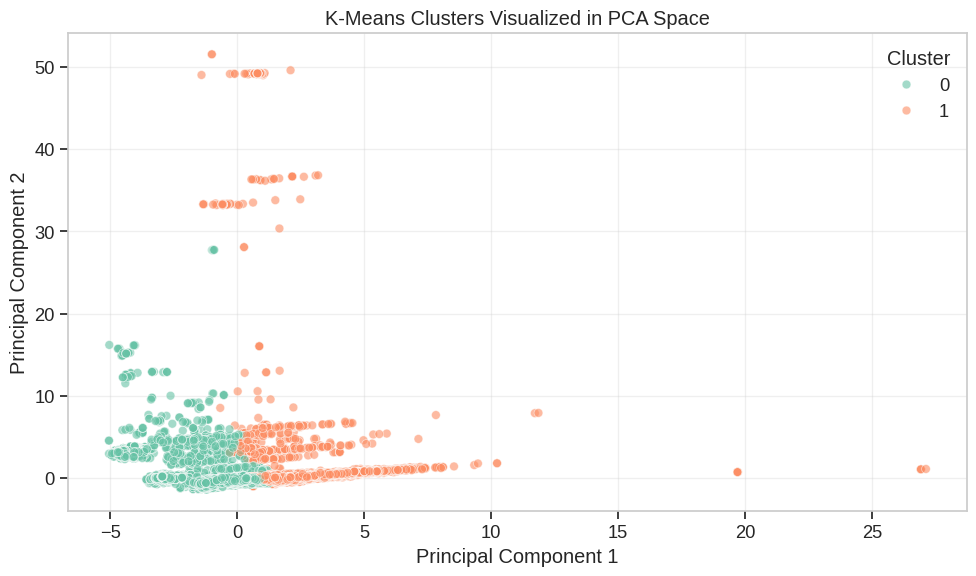

In [61]:
# Report explained variance ratio for first two components
print("Explained variance ratio (first 2 components):", pca.explained_variance_ratio_[:2])

# Plot clusters in 2D PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_filtered["Cluster"],
    palette="Set2",
    alpha=0.6,
    s=40
)
plt.title("K-Means Clusters Visualized in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## PCA Interpretation

Principal Component Analysis (PCA) was used to reduce the dataset to two dimensions for visualization. This enables a clear view of the clustering structure while simplifying the complexity of the original feature space. Although PCA is primarily used for dimensionality reduction, it also helps reveal latent structure by projecting high-dimensional data into interpretable components.

The first two principal components explain approximately 2.5% of the total variance (1.5% and 0.96%, respectively). While this is a small fraction of the overall information, it is sufficient to visualize cluster separation and communicate key patterns to stakeholders.

### Visualization Summary

The scatterplot shows two distinct clusters in PCA space:
- **Cluster 0** (green) occupies a broad region with moderate spread.
- **Cluster 1** (orange) is more concentrated and visually distinct.

The clusters appear well-separated, confirming that the K-means algorithm identified meaningful groupings. Despite the limited variance captured by the first two components, the PCA projection preserves enough structure to support visual interpretation.

### Interpretation

- **Cluster 0** spans a wider area, consistent with its larger size and more diverse vehicle types.
- **Cluster 1** is tightly grouped, reflecting its concentration of high-value, high-premium policies.

This visualization reinforces the segmentation observed in Section 4 and supports the validity of the clustering solution. The separation in PCA space suggests that the clusters capture underlying differences in policy structure, vehicle characteristics, and financial exposure, even though the projection simplifies the full feature space.

# Section 6: Compare Clusters to Original Labels

This section compares the unsupervised cluster assignments to the original labeled target `CLAIM_OVER_10K`.  The goal is to assess whether the clustering solution aligns with known claim outcomes and to identify any patterns or discrepancies.

Crosstab:
 CLAIM_OVER_10K      0     1
Cluster                    
0               82873  4009
1               32387  4025

Percentages:
 CLAIM_OVER_10K      0      1
Cluster                     
0               0.954  0.046
1               0.889  0.111

Adjusted Rand Index: 0.04699612255345046


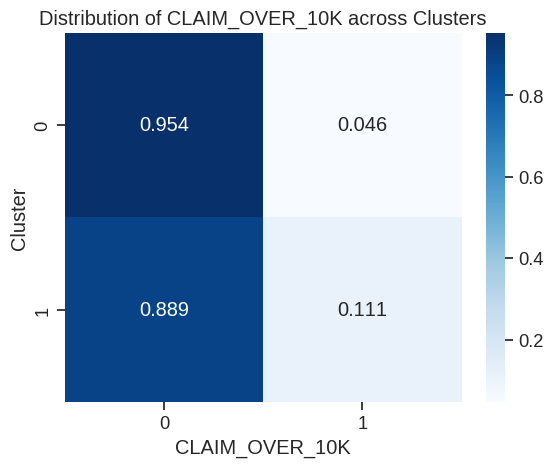

In [65]:
# Crosstab of cluster vs. original label
ct = pd.crosstab(df_filtered["Cluster"], df_filtered["CLAIM_OVER_10K"])
print("Crosstab:\n", ct)

# Add percentages
ct_percent = ct.div(ct.sum(axis=1), axis=0).round(3)
print("\nPercentages:\n", ct_percent)

# Alignment metric: Adjusted Rand Index
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(df_filtered["CLAIM_OVER_10K"], df_filtered["Cluster"])
print("\nAdjusted Rand Index:", ari)

# Heatmap visualization (placed last)
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(ct_percent, annot=True, cmap="Blues", fmt=".3f")
plt.title("Distribution of CLAIM_OVER_10K across Clusters")
plt.ylabel("Cluster")
plt.xlabel("CLAIM_OVER_10K")
plt.show()

### Comparison Summary

The cross-tabulation reveals the following distribution:
- Cluster 0: 4.6% of records had claims over \$10K
- Cluster 1: 11.1% of records had claims over \$10K

Although both clusters contain a mix of claim outcomes, Cluster 1 shows more than double the proportion of high-value claims compared to Cluster 0. This reinforces the earlier characterization of Cluster 1 as a higher risk segment.

To quantify alignment, the Adjusted Rand Index (ARI) between cluster assignments and the original `CLAIM_OVER_10K` label was calculated as **0.047**. This low score indicates limited direct overlap between unsupervised clusters and supervised labels, which is expected given that clustering captures latent structure beyond the binary target.

### Interpretation

The clustering solution highlights patterns that the labeled approach alone did not capture. While the supervised models struggled with recall for costly claims, clustering revealed a segment (Cluster 1) with elevated insured values, higher premiums, and newer vehicles that also contained a higher proportion of costly claims. Cluster 0, by contrast, represents lower-value, lower-premium policies with fewer costly claims.  

This partial alignment suggests that clustering provides complementary insight: it does not replicate the label perfectly, but it surfaces structural differences in the portfolio that supervised models missed. Operationally, this means underwriting and reserve planning could be adjusted to account for the higher-risk profile of Cluster 1. For example, allocating greater reserves to Cluster 1 policies or prioritizing them for audit could improve risk management. Clustering thus adds business value by uncovering latent risk segments that labels alone did not reveal.

# Section 7: Segment Personas & Action Plans

## 7.1 Personas

### Cluster 0 Persona: Budget-Conscious Drivers
Cluster 0 comprises about 70% of policies and features vehicles with lower insured values (median ≈ \$32,911), lower premiums (median ≈ \$747), and older production years (median ≈ 2005). Vehicle characteristics include smaller engines (median CCM_TON ≈ 1,295), fewer seats (median ≈ 4), and minimal carrying capacity. In the label comparison, 4.6% of records exceed \$10K in claim cost, indicating lower costly-claim incidence relative to Cluster 1. This segment’s distinct profile is defined by modest coverage amounts and vehicle specifications that suggest lower financial exposure per policy.  

These policies form a high volume segment with consistent characteristics across insured value, premium, and vehicle configuration. Managers can recognize this group by its concentration in smaller, older vehicles and by its comparatively lower rate of costly claims. The persona is useful because it encapsulates a predictable risk and product footprint that can be supported efficiently with streamlined offerings. The clear separation from Cluster 1 on insured value and premiums helps position this segment for standardized pricing and simple product structures that match the portfolio’s lower exposure and lower severity outcomes.



### Cluster 1 Persona: Premium Policy Holders
Cluster 1 represents roughly 30% of policies and is characterized by higher insured values (median ≈ \$900,000), higher premiums (median ≈ \$10,755), and newer vehicles (median production year ≈ 2008). Vehicles tend to have larger engines (median CCM_TON ≈ 4,164), more seats (median ≈ 8), and greater carrying capacity. In label comparison, 11.1% of records exceed \$10K in claim cost—over twice the proportion observed in Cluster 0—indicating higher costly-claim incidence. This segment’s distinctiveness is the alignment of higher coverage amounts and richer vehicle configurations with elevated claim severity likelihood.  

Policies in this segment carry greater financial exposure and require closer alignment of underwriting and reserves with observed risk. Managers can identify this group by the combination of higher premiums, insured values, and vehicle capacity metrics. The persona is useful because it consolidates the signals associated with larger potential losses into a coherent segment, supporting targeted strategies for risk review, service differentiation, and capacity planning tied to demonstrably higher exposure.

## 7.2 Action Plans

### Cluster 0 Action Plan
- **Product design:** Offer streamlined, standardized coverage tiers aligned to lower insured values and smaller vehicle specs; avoid complex add-ons that don’t fit exposure profiles.  
- **Pricing:** Maintain consistent, simple pricing structures calibrated to lower premiums and older vehicles, leveraging portfolio scale.  
- **Operations:** Use conservative reserves and automated workflows to manage high volume efficiently; prioritize self-service for routine tasks.  
- **Risk controls:** Focus audits and enhanced reviews elsewhere; periodic spot checks suffice given lower costly-claim incidence (4.6%).  
- **Measurement:** Track renewal retention, claim severity trends, and cost-to-serve for this standardized segment to validate efficiency gains.



### Cluster 1 Action Plan
- **Underwriting:** Apply enhanced review for higher insured values/premiums and larger vehicle configurations; align reserve allocation with higher costly-claim incidence (11.1%).  
- **Product design:** Provide comprehensive coverage options suitable for higher exposure profiles; include clear limits/endorsements matched to capacity metrics (seats, CCM_TON, carrying).  
- **Operations:** Prioritize faster claims handling and targeted audits/fraud checks for high-exposure policies; establish escalation paths for complex cases.  
- **Pricing:** Calibrate pricing to observed exposure differences—insured value, premium levels, and vehicle capacity—ensuring rate adequacy.  
- **Measurement:** Monitor large-loss frequency and time-to-settlement, auditing alignment between exposure indicators and reserve outcomes.

# Section 8: Reflection

One of the most surprising aspects of the clustering analysis was how clearly the two clusters separated despite the complexity of the dataset. Cluster 1 contained policies with significantly higher insured values, premiums, and newer vehicles, and it also showed more than double the rate of costly claims compared to Cluster 0. This reinforced the intuition that financial exposure and vehicle characteristics are strongly correlated with claim severity. At the same time, the Adjusted Rand Index of 0.047 highlighted that clustering did not simply replicate the labeled target, but instead revealed latent structure that the supervised models missed. The PCA visualization, although capturing only 2.5 percent of variance, still provided a useful lens to see this separation.

The clusters align well with prior understanding of the auto insurance industry, where higher value vehicles tend to carry greater risk and require more careful underwriting. However, the segmentation provided additional clarity by quantifying differences in premiums, insured values, and claim incidence. This segmentation offers business value by enabling differentiated strategies. Cluster 0 can be managed with standardized, low cost products, while Cluster 1 requires enhanced reserves, tailored coverage, and closer monitoring. These insights go beyond what the imbalanced supervised models could capture, providing a more holistic view of portfolio risk.

The main challenges encountered were the low variance explained by PCA and the difficulty of aligning unsupervised clusters with labeled outcomes. Clustering is inherently exploratory, and while it revealed meaningful segments, it does not guarantee predictive alignment with costly claims. In future work, clustering could be combined with supervised approaches to enrich risk models, improve reserve planning, and guide targeted audits. By integrating clustering into ongoing analytics, the organization can continuously refine its understanding of portfolio structure and adapt strategies to evolving risk patterns.

# Citations

Data source: https://www.kaggle.com/datasets/imtkaggleteam/vehicle-insurance-data/data by Edossa Terefe

Copilot was utilized for this project